# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the world’s longest (1949-present) and most complete (more than 50,000 sampling stations) oceanographic and larval fish data time series. The physical, chemical, and biological data collected at regular time and space intervals help document climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern and central California, collecting a suite of hydrographic and biological data on the station and underway. Data collected at depths down to 500 m include temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could predict the temperature of the water based on the salinity and the depth, as well as possibly other available features.

In [1]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [2]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.7.2


### Utility Functions

In [3]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [8]:
DATA = Path("../data")    # Change to your data folder
assert DATA.exists()

In [10]:
bottle_raw_df = pd.read_csv(DATA / "bottle.csv", low_memory=False)

In [11]:
bottle_info_df = pd.read_csv(
    DATA / "Bottle Field Descriptions.csv",
    encoding="cp1252",
).drop(columns=["Unnamed: 3"])

In [12]:
bottle_info_df[bottle_info_df["Field Name"] == "STheta"]

Field Name                      Units  \
8     STheta  kilograms per cubic meter   

                              Description  
8  Potential Density (Sigma Theta), Kg/M³

In [13]:
bottle_info_df

Field Name                    Units  \
0               Cst_Cnt                     n.a.   
1               Btl_Cnt                     n.a.   
2                Sta_ID                     n.a.   
3              Depth_ID                     n.a.   
4                Depthm                   meters   
..                  ...                      ...   
57                  TA1  micromoles per kilogram   
58                  TA2  micromoles per kilogram   
59                  pH1                 pH scale   
60                  pH2                 pH scale   
61  DIC Quality Comment                     n.a.   

                                          Description  
0   Cast Count - All CalCOFI casts ever conducted,...  
1   Bottle Count - All CalCOFI bottles ever sample...  
2                   Line and Station [Line] [Station]  
3   Uses the Cast_ID prefix ([Century]-[Year][Mont...  
4                              Bottle depth in meters  
..                                                ...  
57  Total Alkalinity micromoles per kilogram solution  
58  Total Alkalinity micromoles per kilogram solut...  
59  pH (the degree of acidity/alkalinity of a solu...  
60  pH (the degree of acidity/alkalinity of a solu...  
61                                    Quality Comment  

[62 rows x 3 columns]

In [14]:
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

Cst_Cnt  Depthm  T_degC   Salnty  O2ml_L    STheta
0             1       0  10.500  33.4400     NaN  25.64900
1             1       8  10.460  33.4400     NaN  25.65600
2             1      10  10.460  33.4370     NaN  25.65400
3             1      19  10.450  33.4200     NaN  25.64300
4             1      20  10.450  33.4210     NaN  25.64300
...         ...     ...     ...      ...     ...       ...
864858    34404       0  18.744  33.4083   5.805  23.87055
864859    34404       2  18.744  33.4083   5.805  23.87072
864860    34404       5  18.692  33.4150   5.796  23.88911
864861    34404      10  18.161  33.4062   5.816  24.01426
864862    34404      15  17.533  33.3880   5.774  24.15297

[864863 rows x 6 columns]

In [15]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  864863 non-null  int64  
 1   Depthm   864863 non-null  int64  
 2   T_degC   853900 non-null  float64
 3   Salnty   817509 non-null  float64
 4   O2ml_L   696201 non-null  float64
 5   STheta   812174 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 39.6 MB


#### Cleaning

Remove the NaN values

<span style="color:red">Implement your solution below</span>

In [17]:
bottle_df.isna().sum()

Cst_Cnt    0
Depthm     0
T_degC     0
Salnty     0
O2ml_L     0
STheta     0
dtype: int64

In [18]:
bottle_df = bottle_df.dropna().reset_index(drop=True)
bottle_df.isna().sum()

Cst_Cnt    0
Depthm     0
T_degC     0
Salnty     0
O2ml_L     0
STheta     0
dtype: int64

### Data Analysis

#### Plot Correlation Matrix with Seaborn

<span style="color:red">Implement your solution below</span>

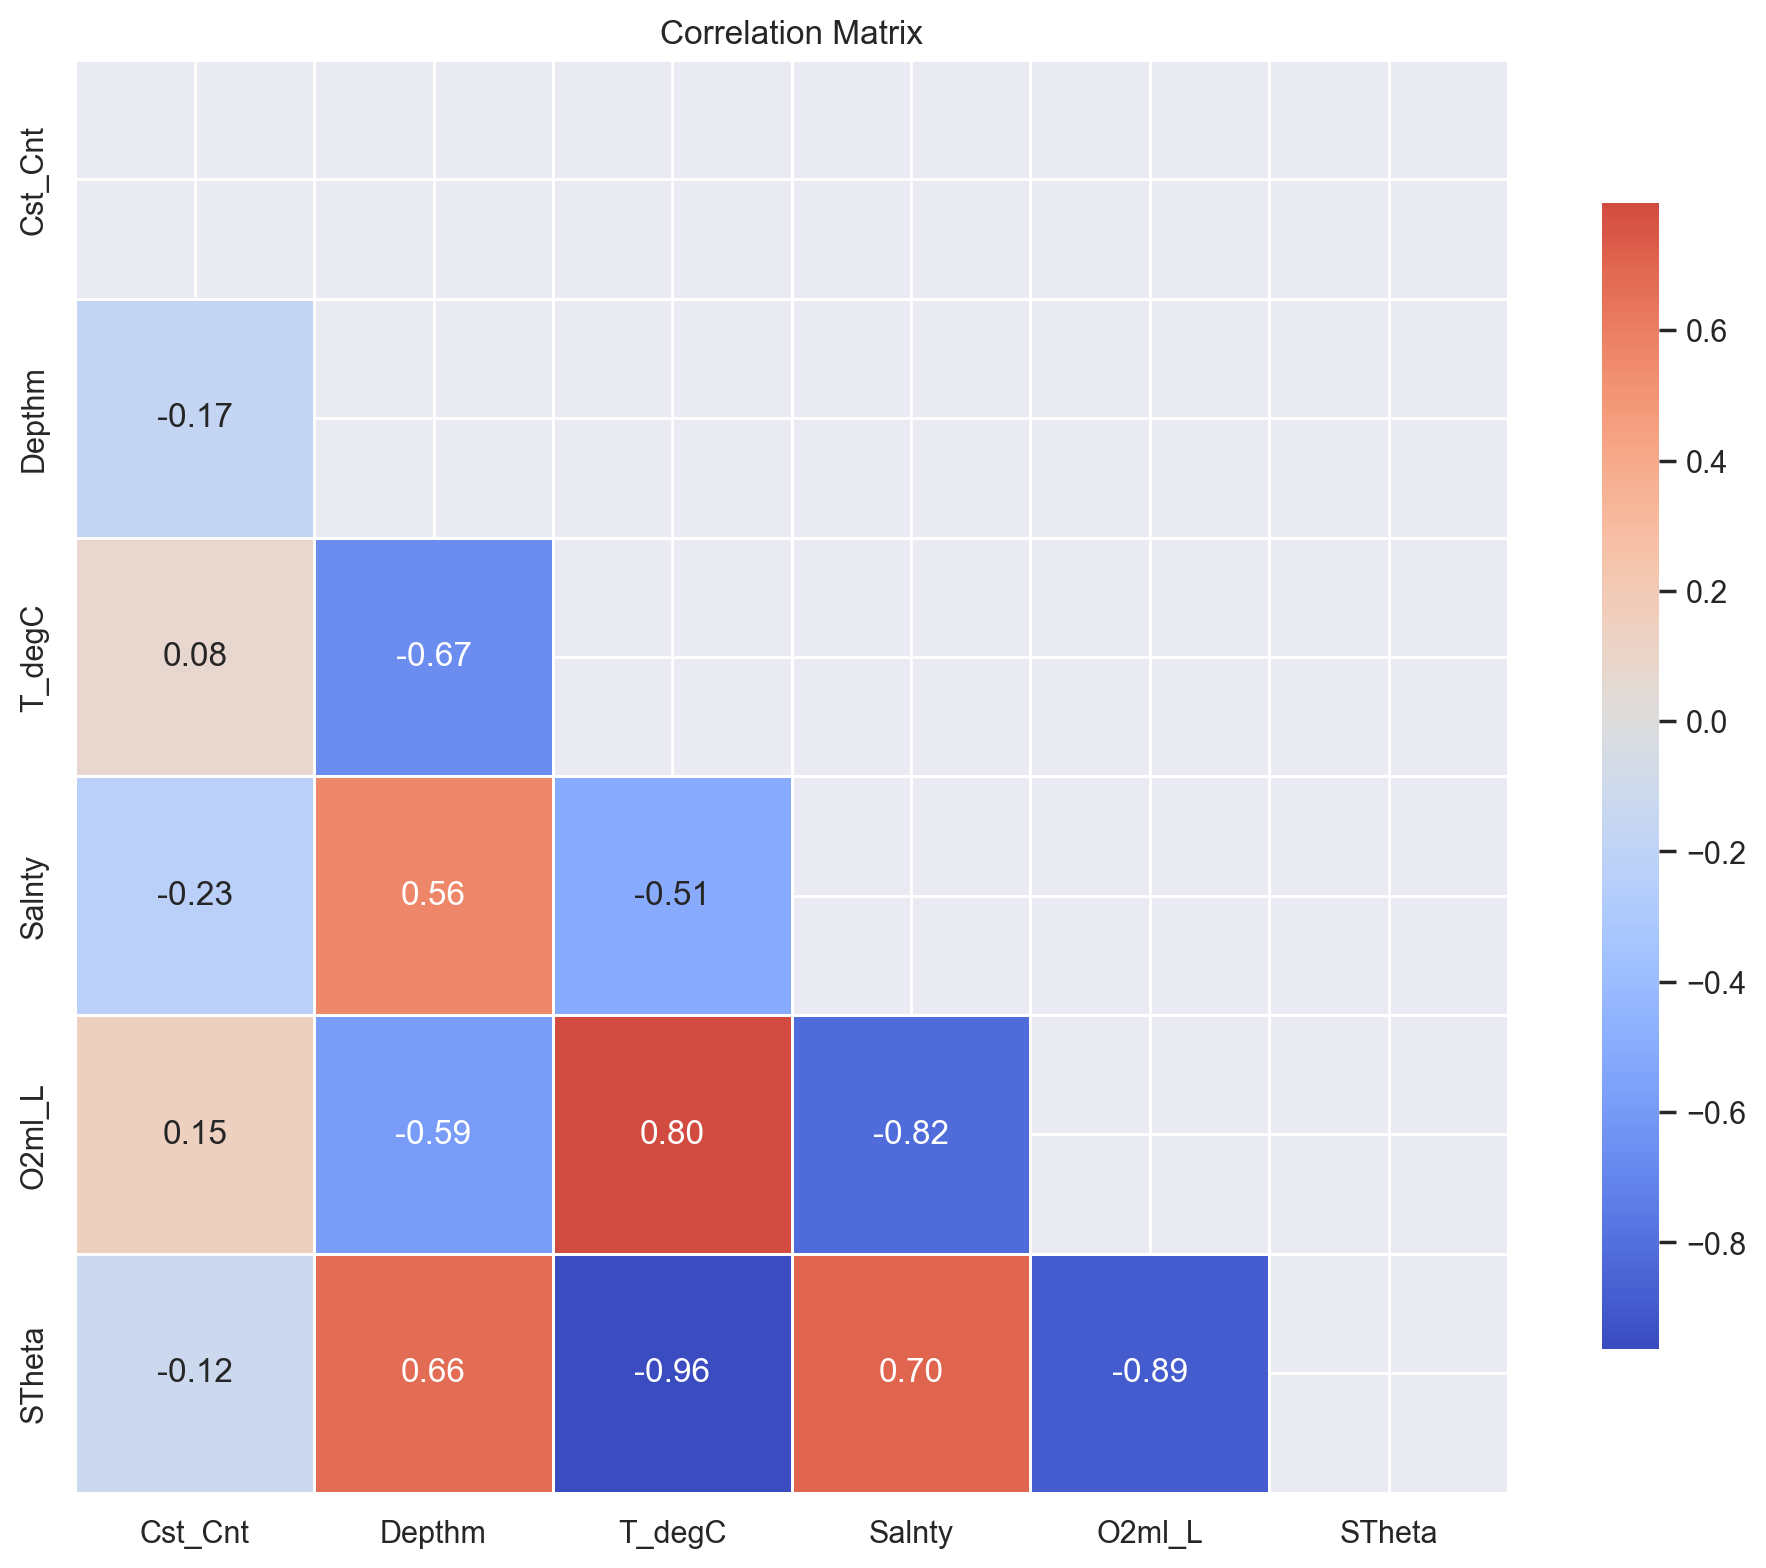

In [20]:
# Plot correlation matrix for numeric features with Seaborn
num_df = bottle_df.select_dtypes(include=[np.number])
corr = num_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### Correlation Plots

Select from the correlation matrix the 4 features involved in the most correlated pairs and plot their relationship.

<span style="color:red">Implement your solution below</span>

In [21]:
# Find the most correlated feature pairs
corr_unstack = corr.where(np.tril(np.ones_like(corr, dtype=bool), k=-1))
corr_unstack = corr_unstack.unstack()

top_corr = corr_unstack.abs().sort_values(ascending=False)
top_corr.head(10)

T_degC  STheta    0.964140
O2ml_L  STheta    0.889568
Salnty  O2ml_L    0.824384
T_degC  O2ml_L    0.795007
Salnty  STheta    0.701585
Depthm  T_degC    0.665744
        STheta    0.664678
        O2ml_L    0.589101
        Salnty    0.563936
T_degC  Salnty    0.505686
dtype: float64

In [22]:

# Get the top 2 most correlated pairs (4 features total)
top_pairs = top_corr.head(2)
features = list(set([pair[0] for pair in top_pairs.index] + [pair[1] for pair in top_pairs.index]))
print(f"\nTop 4 correlated features: {features}")


Top 4 correlated features: ['O2ml_L', 'STheta', 'T_degC']


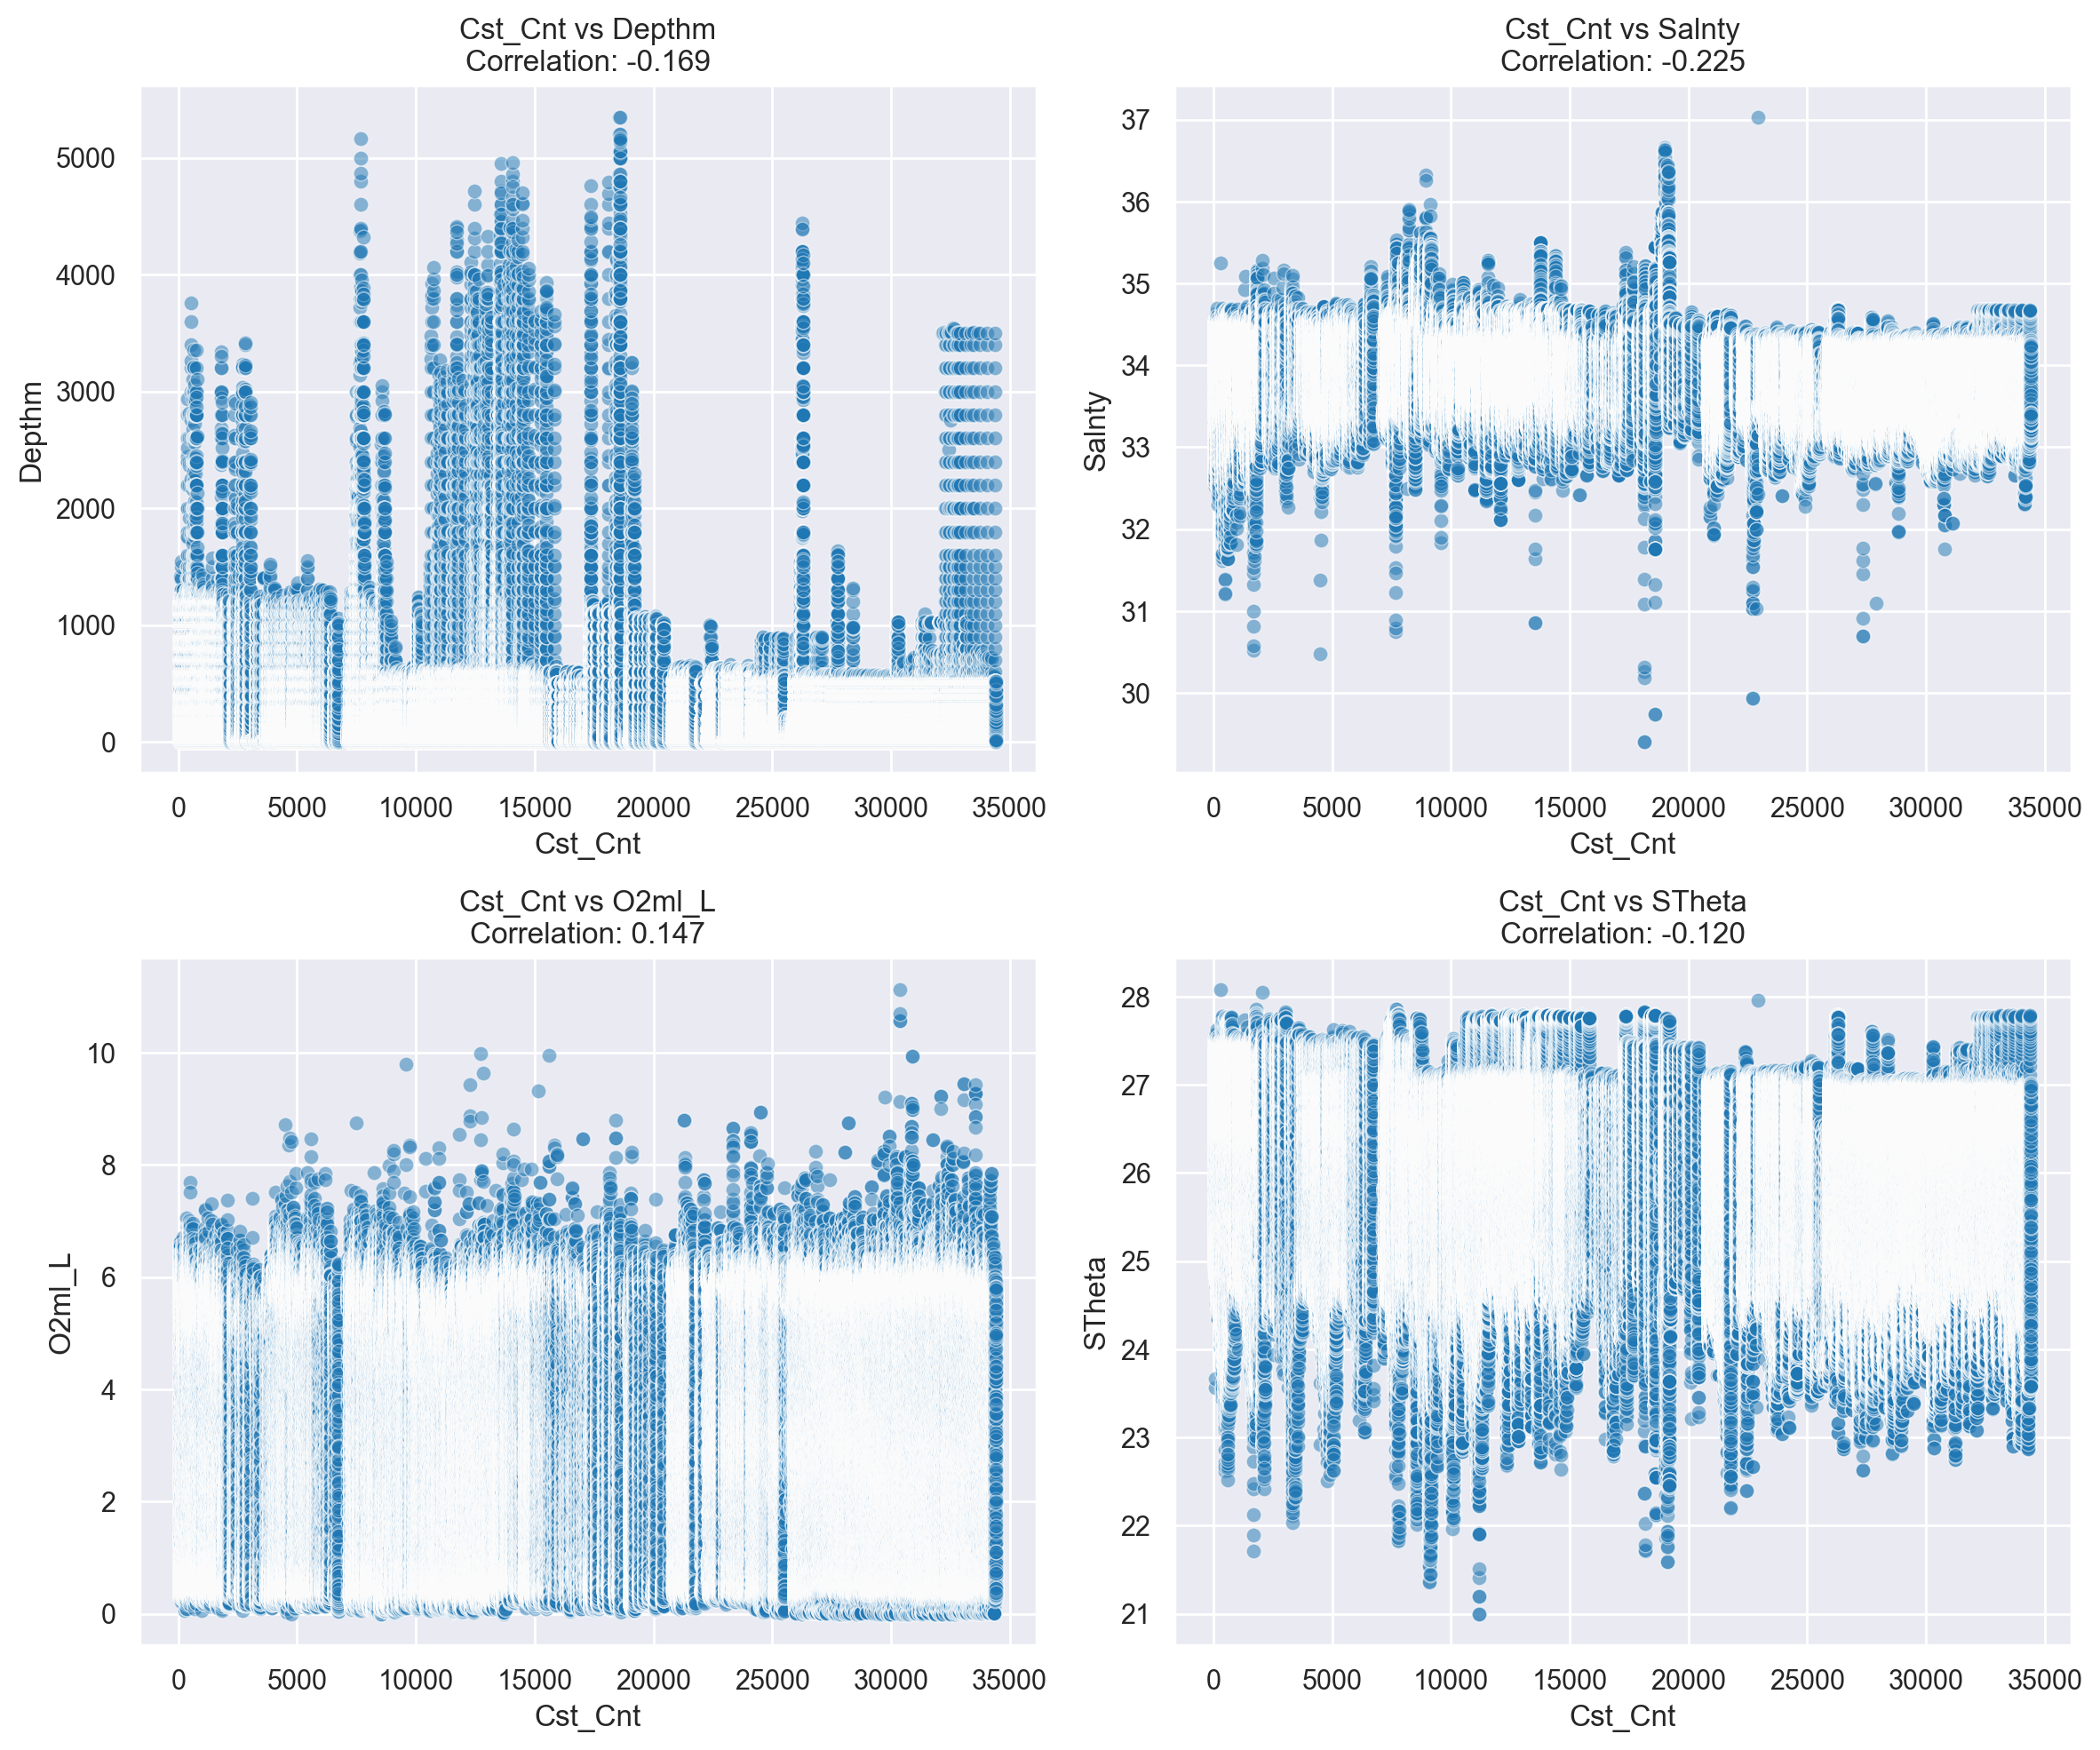

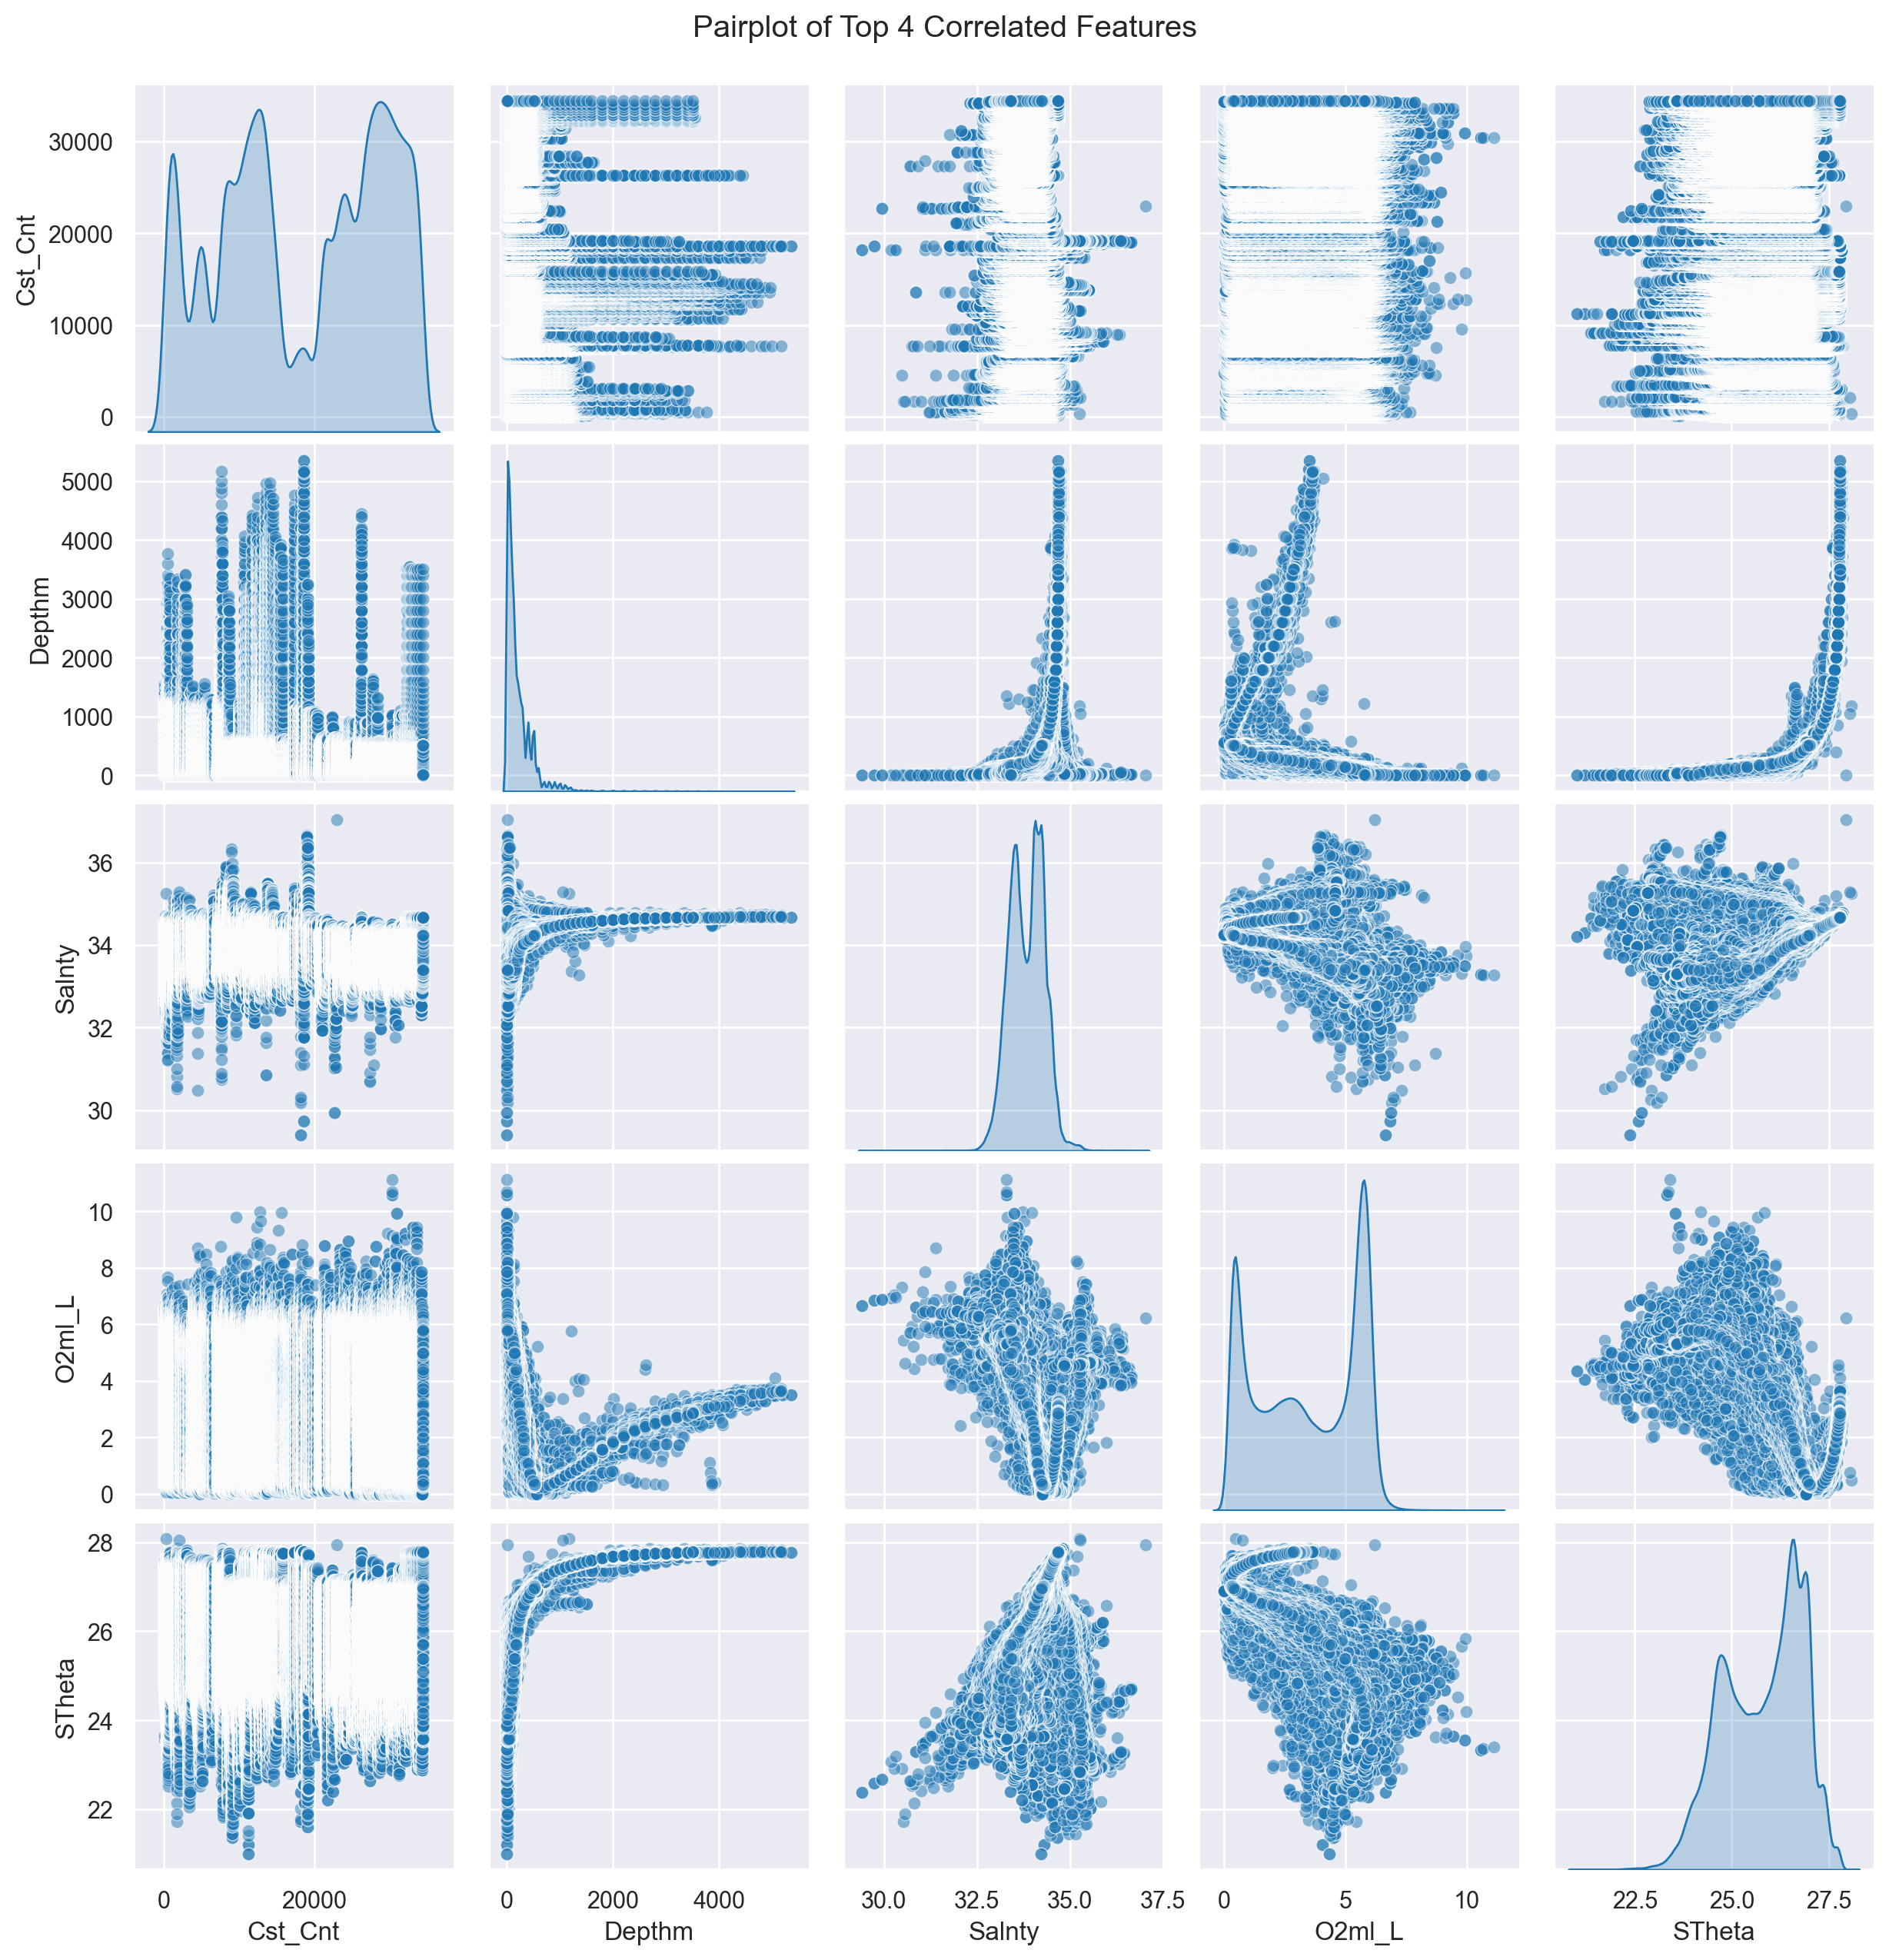

In [25]:
# Plot the relationships between these 4 features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

from itertools import combinations
feature_pairs = list(combinations(features, 2))

# Plot each feature pair
for idx, (feat1, feat2) in enumerate(feature_pairs[:4]):
    sns.scatterplot(data=bottle_df, x=feat1, y=feat2, ax=axes[idx], alpha=0.5)
    corr_value = corr.loc[feat1, feat2]
    axes[idx].set_title(f'{feat1} vs {feat2}\nCorrelation: {corr_value:.3f}')
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Alternative: use pairplot for a more concise visualization of all relationships
sns.pairplot(bottle_df[features], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Top 4 Correlated Features', y=1.02)
plt.show()

#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

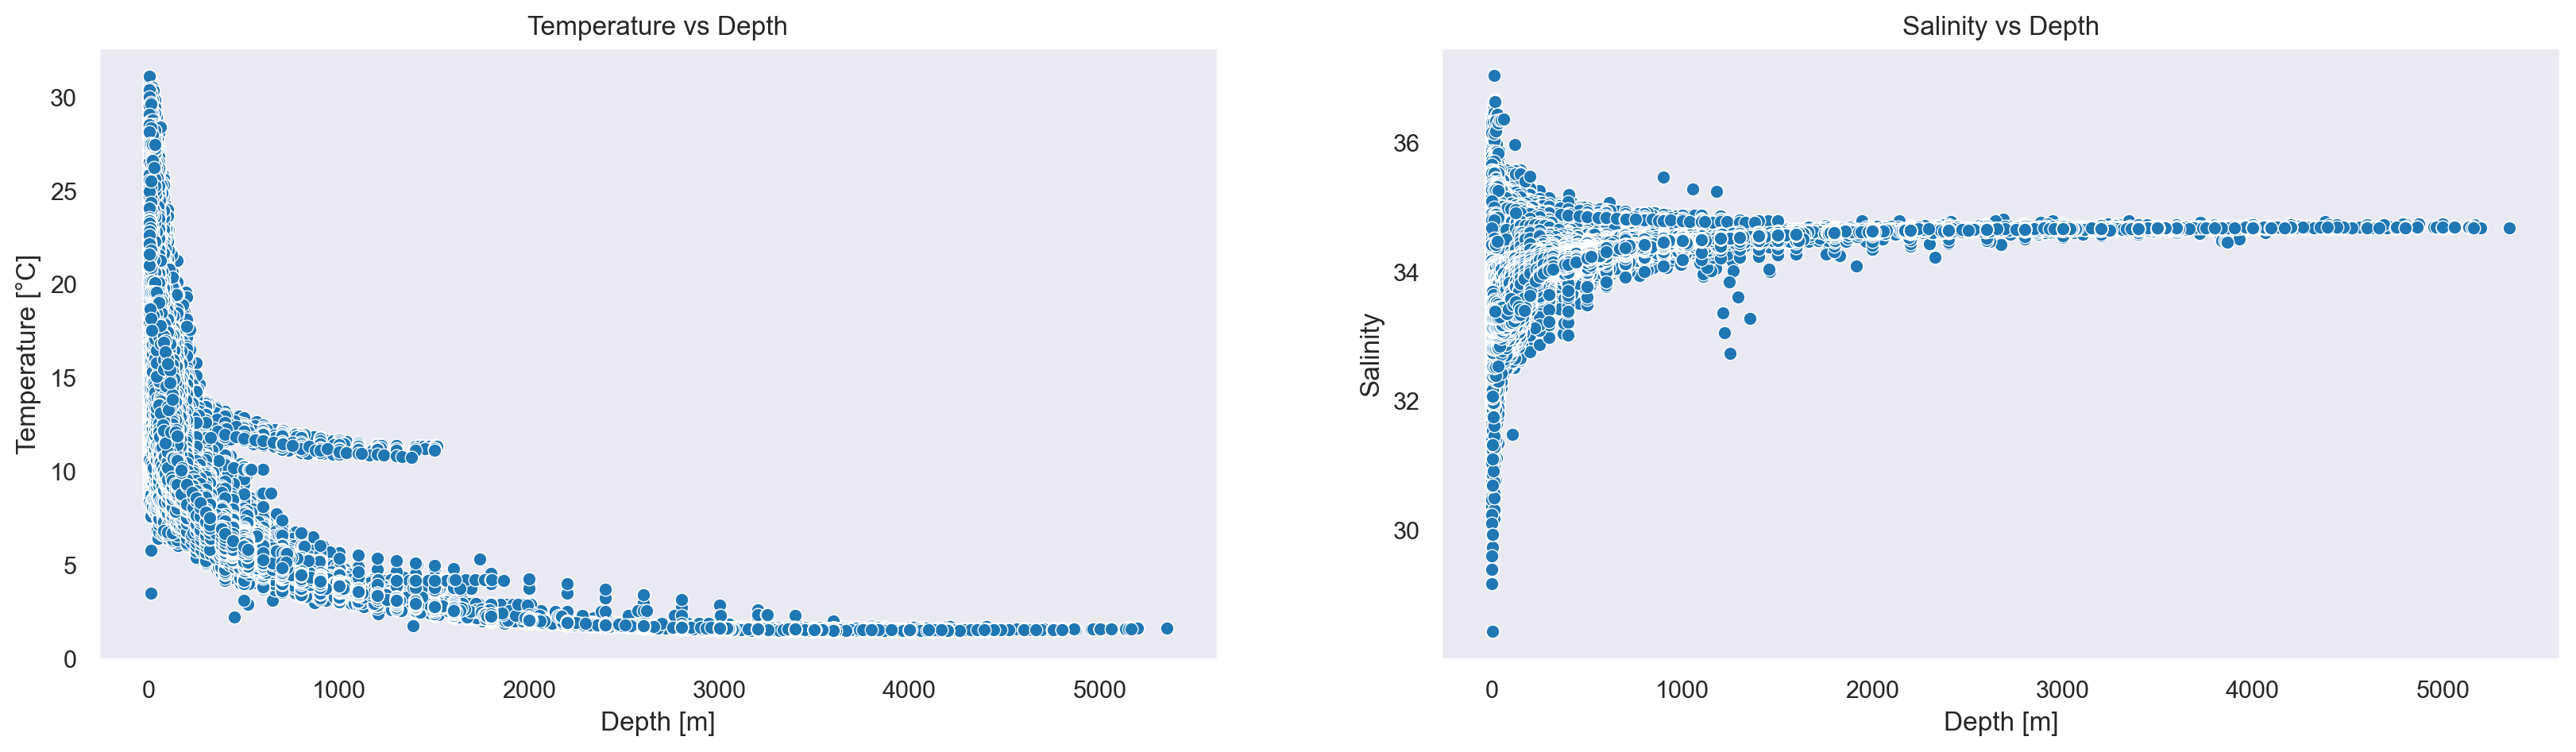

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above, temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot, some points in the upper part of the image show a different trend from the rest of the graph. It is an unexpected behavior because, for instance, at around 1000 m depth, the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html).

- In the second plot, the points converge asymptotically from both high and low salinity values. It means salinity increases with depth in some ocean areas and vice versa.

Suppose we isolate data points with salinity values in the range above the salinity values in the deepest ocean area. In that case, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [12]:
max_depth_salnty = bottle_df.loc[bottle_df.Depthm.idxmax()].Salnty
max_depth_salnty += 0.1  # Margin to stay on the upper side of the asymptote
pprint_var(max_depth_salnty=max_depth_salnty)

bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df   # with max_depth_salnty = 34.85: 6818 rows × 6 columns

max_depth_salnty = 34.78


Cst_Cnt  Depthm  T_degC  Salnty  O2ml_L  STheta
9204        305    1180    3.10  35.250    0.49  28.083
40328      1303     854    4.01  34.930    1.85  27.736
41497      1339     415    7.80  35.090    0.28  27.381
55857      1809    2142    1.98  34.790    1.85  27.817
55862      1809    2688    1.73  34.810    2.47  27.855
...         ...     ...     ...     ...     ...     ...
505873    20509       0   25.18  34.800     NaN  23.137
505874    20509      10   25.18  34.800     NaN  23.138
547993    22262     125    9.42  34.916     NaN  26.987
564387    22937      10   13.08  37.034    6.22  27.954
809349    32242     900    4.21  35.462     NaN  28.139

[9979 rows x 6 columns]

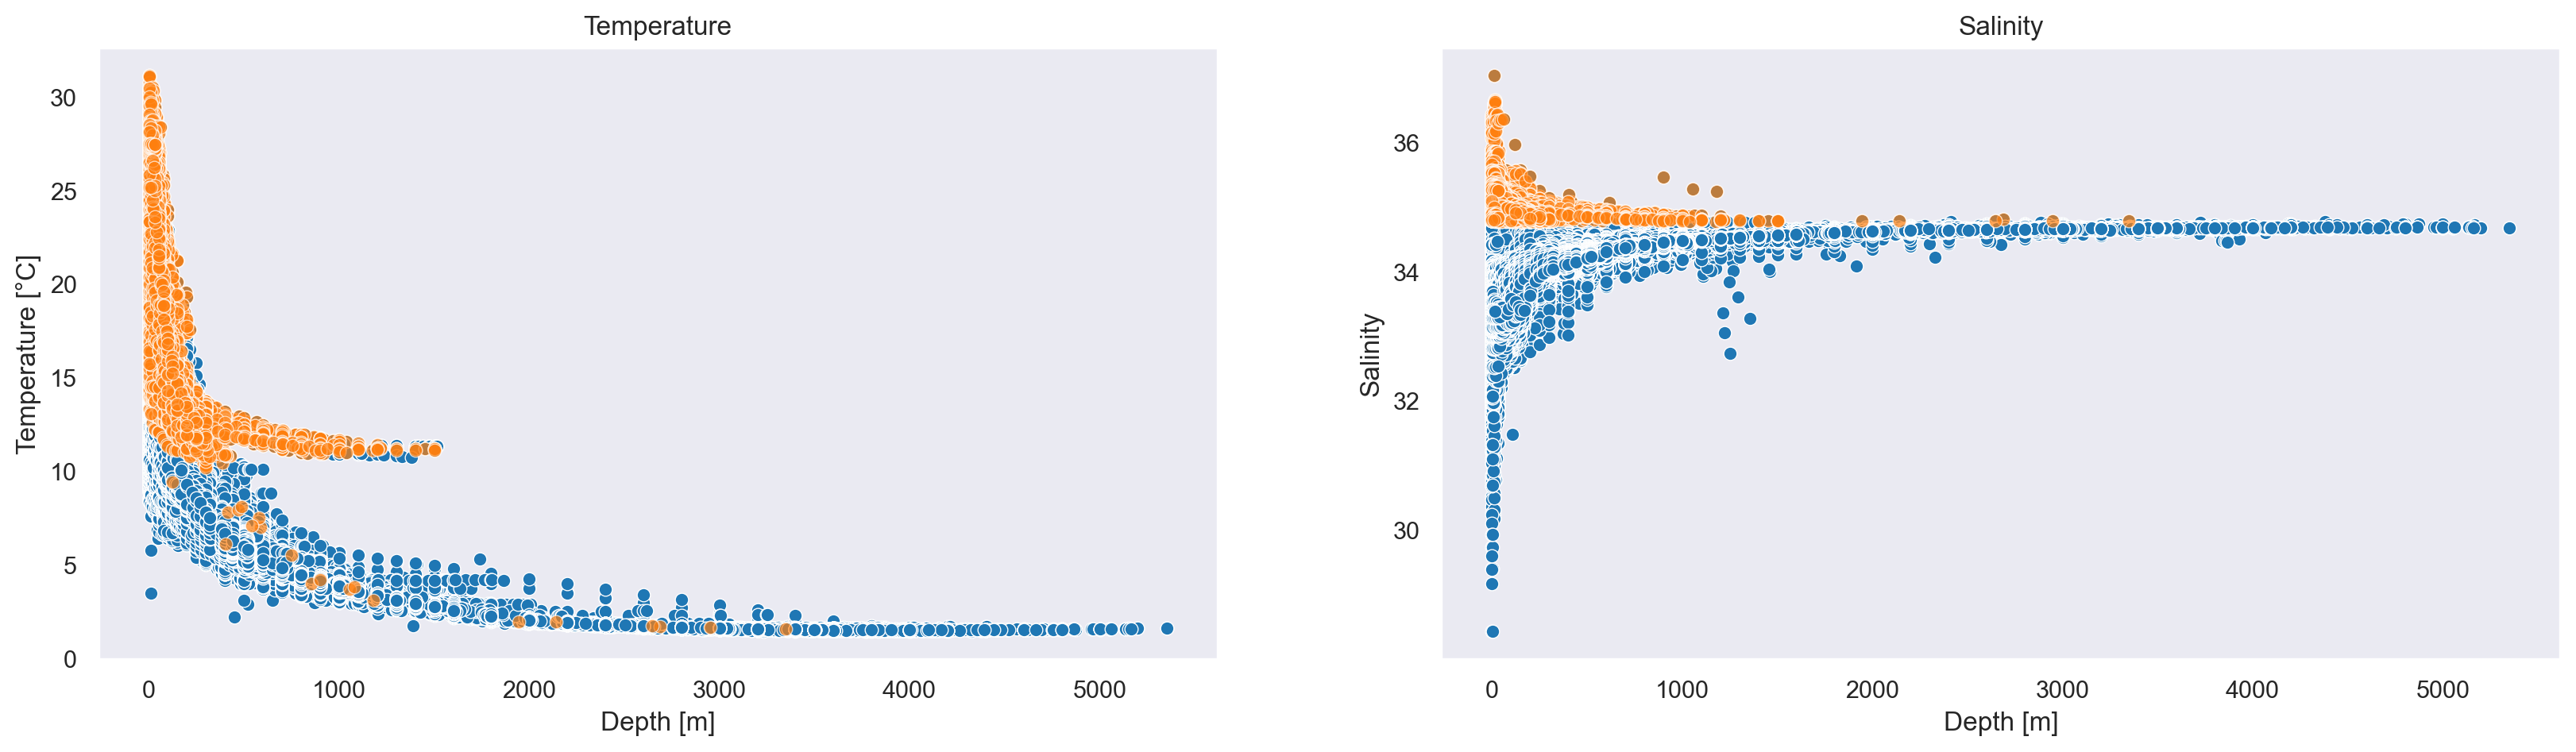

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Splitting the Dataset

<span style="color:red">Implement your solution below</span>

In [24]:
# Split the dataset into training and test sets
target = "T_degC"
if target not in bottle_df.columns:
    raise KeyError(f"Target column '{target}' not found in bottle_df")

# Use numeric features only (exclude the target)
numeric_cols = bottle_df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in numeric_cols if c != target]
print("Features used for prediction:", features)

X = bottle_df[features]
y = bottle_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

Features used for prediction: ['Cst_Cnt', 'Depthm', 'Salnty', 'O2ml_L', 'STheta']
Shapes -> X_train: (529014, 5), X_test: (132254, 5), y_train: (529014,), y_test: (132254,)


#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

<span style="color:red">Implement your solution below</span>

### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

<span style="color:red">Implement your solution below</span>

#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

<span style="color:red">Implement your solution below</span>

### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment on your observations (possibly with tables and plots similar to those in the PCA notebook).

<span style="color:red">Implement your solution below</span>

---